Parse the text from the body of each document using Natural Language Processing (NLP).

Turn each document instance  di  into a feature vector  Xi  using Term Frequency–inverse Document Frequency (TF-IDF).

Apply Dimensionality Reduction to each feature vector  Xi  using t-Distributed Stochastic Neighbor Embedding (t-SNE) to cluster similar research articles in the two dimensional plane  X  embedding  Y1 .

Use Principal Component Analysis (PCA) to project down the dimensions of  X  to a number of dimensions that will keep .95 variance while removing noise and outliers in embedding  Y2 .

Apply k-means clustering on  Y2 , where  k  is 20, to label each cluster on  Y1 .

Apply Topic Modeling on  X  using Latent Dirichlet Allocation (LDA) to discover keywords from each cluster.

Investigate the clusters visually on the plot, zooming down to specific articles as needed, and via classification using Stochastic Gradient Descent (SGD).

In [2]:
from google.colab import drive
#drive.mount('/content/drive/')

In [1]:
import pandas as pd
df = pd.read_csv('/content/drive/My Drive/edited_all_news_set2.csv')

In [ ]:
#df.head()

In [ ]:
# to handle duplicates
df.drop_duplicates(['abstract', 'body_text'], inplace=True)
df['abstract'].describe(include='all')

In [4]:
# to count words
df['body_word_count'] = df['processed_content'].apply(lambda x: len(x.strip().split()))  # word count in abstract

df['body_unique_words']=df['processed_content'].apply(lambda x:len(set(str(x).split())))  # number of unique words in body
df.head()

,Unnamed: 0,_id,topic,content,processed_content,body_word_count,body_unique_words
0,0,5f04e496ef217aae6a201f71,"[""National""]","[""The West Bengal government on Tuesday decide...",west bengal govern tuesday decid impos complet...,215,110
1,1,5f04e498ef217aae6a201f72,"[""Business""]","[""The government is weighing the pros and cons...",govern weigh pros con halt import includ china...,140,109
2,2,5f04e49aef217aae6a201f73,"[""National""]","[""The Central Board of Secondary Education (CB...",central board secondari educ cbse slash syllab...,143,110
3,3,5f04e49def217aae6a201f74,"[""International""]","[""The World Health Organization on Tuesday ack...",world health organ tuesday acknowledg emerg ev...,35,32
4,4,5f04e49fef217aae6a201f75,"[""International""]","[""President Donald Trump on Tuesday formally s...",presid donald trump tuesday formal start withd...,320,203


In [ ]:
#df.to_csv('/content/drive/My Drive/all_news_with_count.csv')

In [ ]:
#df.describe()

In [ ]:
#Handling multiple languages
#Next we are going to determine the language of each paper in the dataframe.
#Not all of the sources are English and the language needs to be identified so that we know how handle these instances

from tqdm import tqdm
from langdetect import detect
from langdetect import DetectorFactory

# set seed
DetectorFactory.seed = 0

# hold label - language
languages = []

# go through each text
for ii in tqdm(range(0,len(df))):
    # split by space into list, take the first x intex, join with space
    text = df.iloc[ii]['body_text'].split(" ")
    
    lang = "en"
    try:
        if len(text) > 50:
            lang = detect(" ".join(text[:50]))
        elif len(text) > 0:
            lang = detect(" ".join(text[:len(text)]))
    # ught... beginning of the document was not in a good format
    except Exception as e:
        all_words = set(text)
        try:
            lang = detect(" ".join(all_words))
        # what!! :( let's see if we can find any text in abstract...
        except Exception as e:
            
            try:
                # let's try to label it through the abstract then
                lang = detect(df.iloc[ii]['abstract_summary'])
            except Exception as e:
                lang = "unknown"
                pass
    
    # get the language    
    languages.append(lang)

In [ ]:
from pprint import pprint

languages_dict = {}
for lang in set(languages):
    languages_dict[lang] = languages.count(lang)
    
print("Total: {}\n".format(len(languages)))
pprint(languages_dict)

In [ ]:
df['language'] = languages
plt.bar(range(len(languages_dict)), list(languages_dict.values()), align='center')
plt.xticks(range(len(languages_dict)), list(languages_dict.keys()))
plt.title("Distribution of Languages in Dataset")
plt.show()

In [2]:
#vectorization
from sklearn.feature_extraction.text import TfidfVectorizer
def vectorize(text, maxx_features):
    
    vectorizer = TfidfVectorizer(max_features=maxx_features)
    X = vectorizer.fit_transform(text)
    return X

In [3]:
text = df['processed_content'].values
X = vectorize(text, 2 ** 12)
X.shape

(3092, 4096)

PCA & Clustering
Let's see how much we can reduce the dimensions while still keeping 95% variance. We will apply Principle Component Analysis (PCA) to our vectorized data. The reason for this is that by keeping a large number of dimensions with PCA, you don’t destroy much of the information, but hopefully will remove some noise/outliers from the data, and make the clustering problem easier for k-means. Note that X_reduced will only be used for k-means, t-SNE will still use the original feature vector X that was generated through tf-idf on the NLP processed text.

In [4]:
from sklearn.decomposition import PCA

pca = PCA(n_components=0.95, random_state=42)
X_reduced= pca.fit_transform(X.toarray())
X_reduced.shape

(3092, 1561)

To separate the literature, k-means will be run on the vectorized text. Given the number of clusters, k, k-means will categorize each vector by taking the mean distance to a randomly initialized centroid. The centroids are updated iteratively.

In [5]:
from sklearn.cluster import KMeans

How many clusters?
To find the best k value for k-means we'll look at the distortion at different k values. Distortion computes the sum of squared distances from each point to its assigned center. When distortion is plotted against k there will be a k value after which decreases in distortion are minimal. This is the desired number of clusters

In [6]:
from sklearn import metrics
from scipy.spatial.distance import cdist
import numpy as np

# run kmeans with many different k
distortions = []
K = range(28, 30)
for k in K:
    k_means = KMeans(n_clusters=k, random_state=42).fit(X_reduced)
    k_means.fit(X_reduced)
    distortions.append(sum(np.min(cdist(X_reduced, k_means.cluster_centers_, 'euclidean'), axis=1)) / X.shape[0])
    #print('Found distortion for {} clusters'.format(k))

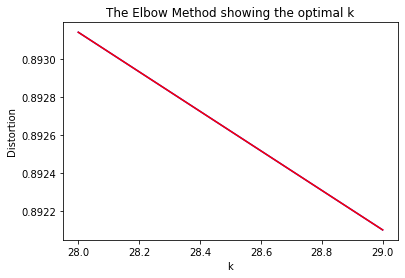

In [7]:
import matplotlib.pyplot as plt

X_line = [K[0], K[-1]]
Y_line = [distortions[0], distortions[-1]]

# Plot the elbow
plt.plot(K, distortions, 'b-')
plt.plot(X_line, Y_line, 'r')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In [8]:
k = 30
kmeans = KMeans(n_clusters=k, random_state=42)
y_pred = kmeans.fit_predict(X_reduced)
df['y'] = y_pred

Dimensionality Reduction with t-SNE
Using t-SNE we can reduce our high dimensional features vector to 2 dimensions. By using the 2 dimensions as x,y coordinates, the body_text can be plotted.

t-Distributed Stochastic Neighbor Embedding (t-SNE) reduces dimensionality while trying to keep similar instances close and dissimilar instances apart. It is mostly used for visualization, in particular to visualize clusters of instances in high-dimensional space

In [9]:
from sklearn.manifold import TSNE

tsne = TSNE(verbose=1, perplexity=100, random_state=42)
X_embedded = tsne.fit_transform(X.toarray())

[t-SNE] Computing 301 nearest neighbors...
[t-SNE] Indexed 3092 samples in 1.713s...
[t-SNE] Computed neighbors for 3092 samples in 85.875s...
[t-SNE] Computed conditional probabilities for sample 1000 / 3092
[t-SNE] Computed conditional probabilities for sample 2000 / 3092
[t-SNE] Computed conditional probabilities for sample 3000 / 3092
[t-SNE] Computed conditional probabilities for sample 3092 / 3092
[t-SNE] Mean sigma: 0.383366
[t-SNE] KL divergence after 250 iterations with early exaggeration: 68.665939
[t-SNE] KL divergence after 1000 iterations: 1.334992


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


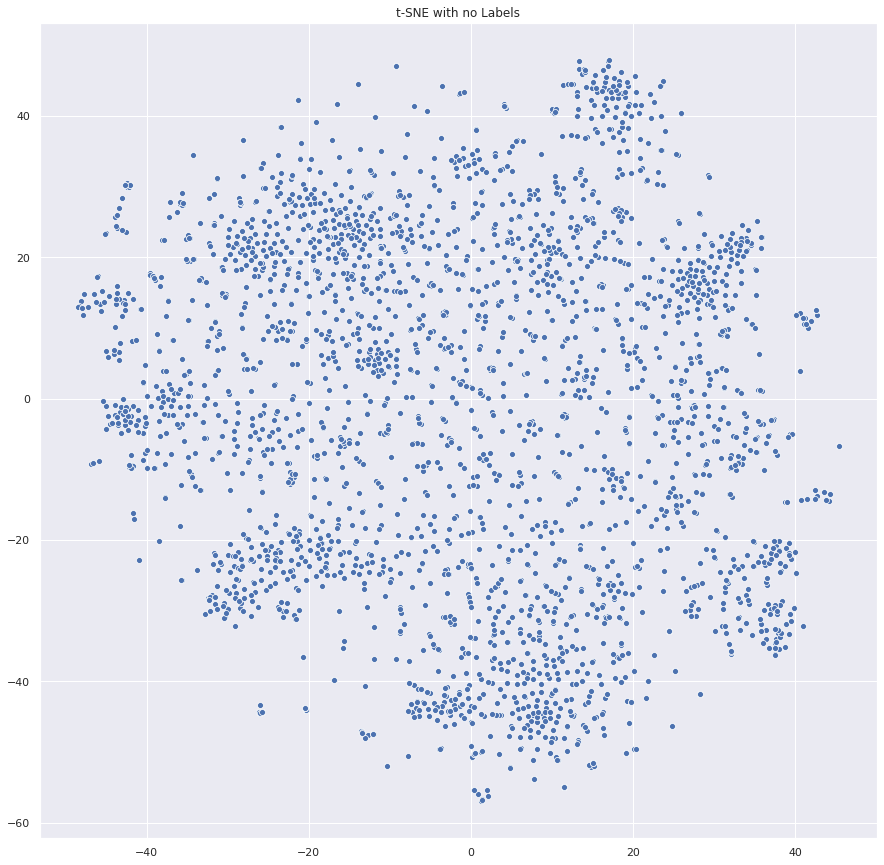

In [10]:
from matplotlib import pyplot as plt
import seaborn as sns

# sns settings
sns.set(rc={'figure.figsize':(15,15)})

# colors
palette = sns.color_palette("bright", 1)

# plot
sns.scatterplot(X_embedded[:,0], X_embedded[:,1], palette=palette)
plt.title('t-SNE with no Labels')
plt.savefig("t-sne_covid19.png")
plt.show()

This looks pretty bland. There are some clusters we can immediately detect, but the many instances closer to the center are harder to separate. t-SNE did a good job at reducing the dimensionality, but now we need some labels. Let's use the clusters found by k-means as labels. This will help visually separate different concentrations of topics.

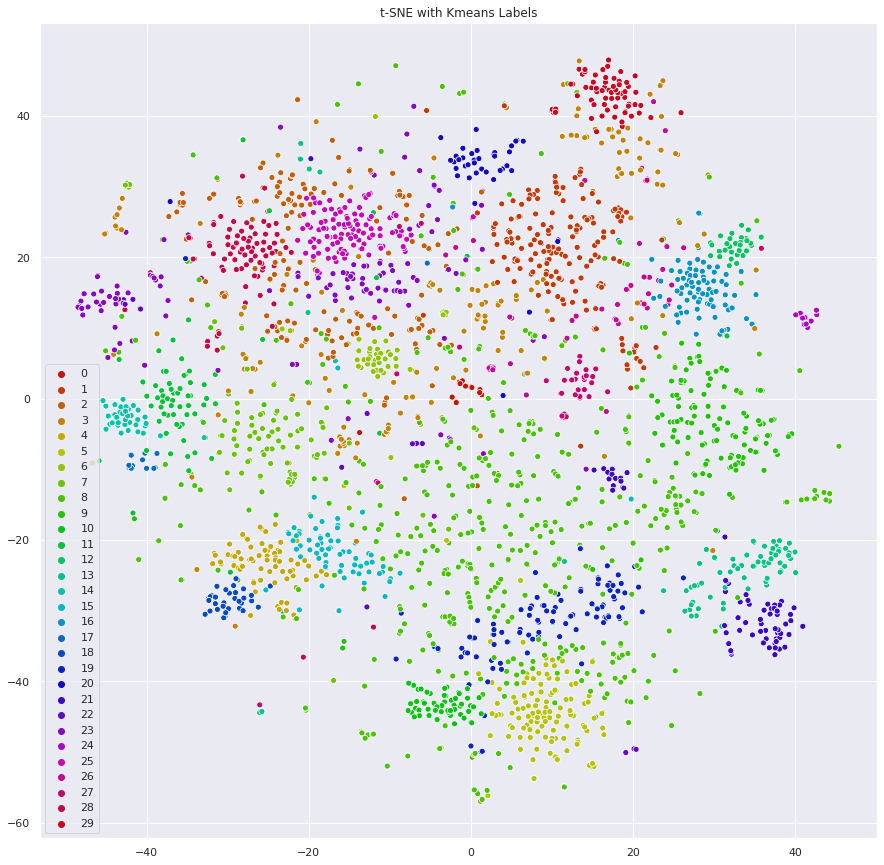

In [12]:
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns

# sns settings
sns.set(rc={'figure.figsize':(15,15)})

# colors
palette = sns.hls_palette(30, l=.4, s=.9)

# plot
sns.scatterplot(X_embedded[:,0], X_embedded[:,1], hue=y_pred, legend='full', palette=palette)
plt.title('t-SNE with Kmeans Labels')
plt.savefig("improved_cluster_tsne.png")
plt.show()

The labeled plot gives better insight into how the papers are grouped. It is interesting that both k-means and t-SNE are able to agree on certain clusters even though they were ran independetly. The location of each paper on the plot was determined by t-SNE while the label (color) was determined by k-means. If we look at a particular part of the plot where t-SNE has grouped many articles forming a cluster, it is likely that k-means is uniform in the labeling of this cluster (most of the cluster is the same color). This behavior shows that structure within the literature can be observed and measured to some extent.

Now there are other cases where the colored labels (k-means) are spread out on the plot (t-SNE). This is a result of t-SNE and k-means finding different connections in the higher dimensional data. The topics of these papers often intersect so it hard to cleanly separate them. This effect can be observed in the formation of subclusters on the plot. These subclusters are a conglomeration of different k-means labels but may share some connection determined by t-SNE.

This organization of the data does not act as a simple search engine. The clustering + dimensionality reduction is performed on the mathematical similarities of the publications. As an unsupervised approach, the algorithms may even find connections that were unnaparent to humans. This may highlight hidden shared information and advance further research.

Topic Modeling on Each Cluster
Now we will attempt to find the most significant words in each clusters. K-means clustered the articles but did not label the topics. Through topic modeling we will find out what the most important terms for each cluster are. This will add more meaning to the cluster by giving keywords to quickly identify the themes of the cluster.

For topic modeling, we will use LDA (Latent Dirichlet Allocation). In LDA, each document can be described by a distribution of topics and each topic can be described by a distribution of words.

In [18]:
#from sklearn.decomposition import LatentDirichletAllocation
#from sklearn.feature_extraction.text import CountVectorizer

In [19]:
#First we will create 20 vectorizers, one for each of our cluster labels

#vectorizers = []
    
#for ii in range(0, 20):
    # Creating a vectorizer
 #   vectorizers.append(CountVectorizer(min_df=5, max_df=0.9, stop_words='english', lowercase=True, token_pattern='[a-zA-Z\-][a-zA-Z\-]{2,}'))

In [31]:
#vectorizers[0]

In [32]:
#Now we will vectorize the data from each of our clusters

#vectorized_data = []

#for current_cluster, cvec in enumerate(vectorizers):
 #   try:
 #       vectorized_data.append(cvec.fit_transform(df.loc[df['y'] == current_cluster, 'processed_text']))
 #   except Exception as e:
 #       print("Not enough instances in cluster: " + str(current_cluster))
 #       vectorized_data.append(None)
#len(vectorized_data)

In [33]:
 #number of topics per cluster
#NUM_TOPICS_PER_CLUSTER = 20

#lda_models = []
#for ii in range(0, 20):
    # Latent Dirichlet Allocation Model
#    lda = LatentDirichletAllocation(n_components=NUM_TOPICS_PER_CLUSTER, max_iter=10, learning_method='online',verbose=False, random_state=42)
#    lda_models.append(lda)
    
#lda_models[0]

In [23]:
#For each cluster, we had created a correspoding LDA model in the previous step. We will now fit_transform all the LDA models on their respective cluster vectors

#clusters_lda_data = []

#for current_cluster, lda in enumerate(lda_models):
    # print("Current Cluster: " + str(current_cluster))
    
 #   if vectorized_data[current_cluster] != None:
  #      clusters_lda_data.append((lda.fit_transform(vectorized_data[current_cluster])))

In [24]:
#Extracts the keywords from each cluster

# Functions for printing keywords for each topic
#def selected_topics(model, vectorizer, top_n=3):
#    current_words = []
#    keywords = []
    
#    for idx, topic in enumerate(model.components_):
#        words = [(vectorizer.get_feature_names()[i], topic[i]) for i in topic.argsort()[:-top_n - 1:-1]]
#        for word in words:
#            if word[0] not in current_words:
#                keywords.append(word)
#                current_words.append(word[0])
                
 #   keywords.sort(key = lambda x: x[1])  
  #  keywords.reverse()
   # return_values = []
   # for ii in keywords:
    #    return_values.append(ii[0])
    #return return_values


In [34]:
#Append list of keywords for a single cluster to 2D list of length NUM_TOPICS_PER_CLUSTER

#all_keywords = []
#for current_vectorizer, lda in enumerate(lda_models):
    # print("Current Cluster: " + str(current_vectorizer))

 #   if vectorized_data[current_vectorizer] != None:
  #      all_keywords.append(selected_topics(lda, vectorizers[current_vectorizer]))
#all_keywords[0][:10]

In [13]:
#for extracting features
n_topics = 30
random_state = 0

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
vec = TfidfVectorizer(max_features=5000, stop_words="english", max_df=0.95, min_df=2)
features = vec.fit_transform(df.processed_content)

#for topic modelling

from sklearn.decomposition import NMF
cls = NMF(n_components=n_topics, random_state=random_state)
cls.fit(features)

NMF(alpha=0.0, beta_loss='frobenius', init=None, l1_ratio=0.0, max_iter=200,
    n_components=30, random_state=0, shuffle=False, solver='cd', tol=0.0001,
    verbose=0)

In [14]:
# list of unique words found by the vectorizer
feature_names = vec.get_feature_names()

# number of most influencing words to display per topic
n_top_words = 15

for i, topic_vec in enumerate(cls.components_):
    print(i, end=' ')
    # topic_vec.argsort() produces a new array
    # in which word_index with the least score is the
    # first array element and word_index with highest
    # score is the last array element. Then using a
    # fancy indexing [-1: -n_top_words-1:-1], we are
    # slicing the array from its end in such a way that
    # top `n_top_words` word_index with highest scores
    # are returned in desceding order
    for fid in topic_vec.argsort()[-1:-n_top_words-1:-1]:
        print(feature_names[fid], end=' ')
    print()

0 peopl time work like need women feel lockdown help thing life home think good today 
1 case death covid state number coronavirus infect report total talli peopl lockdown health rate juli 
2 china chines india beij countri trade econom militari hong border kong foreign global pompeo nation 
3 congress pilot gehlot mlas parti rajasthan sachin gandhi leader ashok chief assembl rahul polit govern 
4 student univers exam onlin class semest colleg examin academ cours immigr institut educ intern program 
5 polic say arrest investig accus station kill alleg milit attack forc offic case personnel mumbai 
6 cent crore quarter bank sector compani growth profit year econom economi say june revenu lakh 
7 sushant rajput singh actor rhea chakraborti suicid mumbai ankita death bihar demis bandra bechara lokhand 
8 vaccin trial phase drug clinic dose research develop covid immun oxford human studi say candid 
9 leagu season player liverpool club game team champion chelsea madrid sport klopp premier 

In [15]:
# to identify topic of a new document
new_articles = [
    '''I have arranged for a loudspeaker system on a cart. The teachers are asked to turn-wise go with the cart and park it at a feasible location and impart lessons from there. It cannot match up to classroom learning but will ensure some learning,” he said. This strange new way of educating school students is not uncommon in the country’s rural parts. The lockdown induced by COVID-19 in March prompted schools and colleges to move to the virtual world for teaching and learning activities. But weak internet penetration has turned e-education into a distant dream for many children in the rural areas. ''',
    '''World Cup squad. The side led by Sourav Ganguly in 2003 had experienced top-order batsmen such as Virender Sehwag, Sachin Tendulkar, Rahul Dravid, and Ganguly. Virat Kohli’s team in 2019 also had a strong top-order with Shikhar Dhawan, Rohit Sharma and Kohli himself. Ganguly’s pace bowling department looked strong with four top-class seamers in Zaheer Khan, Ashish Nehra, Ajit Agarkar and veteran Javagal Srinath. Kohli had Jasprit Bumrah, Bhuvneshwar Kumar and Mohammed Shami - all at top of their game. Ganguly’s spin department was sorted with veterans Harbhajan Singh and Anil Kumble, while Kohli’s spin bowling options were Yuzvendra Chahal, Kuldeep Yadav and Ravindra Jadeja '''
]
# first transform the text into features using vec
# then pass it to transform of cls
# the result will be a matrix of shape [2, 10]
# then we sort the topic id based on the score using argsort
# and take the last one (with the highest score) for each row using `[:,-1]` indexing
cls.transform(vec.transform(new_articles)).argsort(axis=1)[:,-1]

array([28, 10])

In [ ]:
#Save current outputs to file
#Re-running some parts of the notebook (especially vectorization and t-SNE) are time intensive tasks. We want to make sure that the important outputs for generating the bokeh plot are saved for future use.

#f=open('topics.txt','w')

#count = 0

#for ii in all_keywords:

 #   if vectorized_data[count] != None:
  #      f.write(', '.join(ii) + "\n")
   # else:
    #    f.write("Not enough instances to be determined. \n")
     #   f.write(', '.join(ii) + "\n")
    #count += 1

#f.close()

In [ ]:
import pickle

# save the COVID-19 DataFrame, too large for github
pickle.dump(df, open("df_covid.p", "wb" ))

# save the final t-SNE
pickle.dump(X_embedded, open("X_embedded.p", "wb" ))

# save the labels generate with k-means(20)
pickle.dump(y_pred, open("y_pred.p", "wb" ))

Classify

Though arbitrary, after running kmeans, the data is now 'labeled'. This means that we now use supervised learning to see how well the clustering generalizes. This is just one way to evaluate the clustering. If k-means was able to find a meaningful split in the data, it should be possible to train a classifier to predict which cluster a given instance should belong to.

In [16]:
# function to print out classification model report
def classification_report(model_name, test, pred):
    from sklearn.metrics import precision_score, recall_score
    from sklearn.metrics import accuracy_score
    from sklearn.metrics import f1_score
    
    print(model_name, ":\n")
    print("Accuracy Score: ", '{:,.3f}'.format(float(accuracy_score(test, pred)) * 100), "%")
    print("     Precision: ", '{:,.3f}'.format(float(precision_score(test, pred, average='macro')) * 100), "%")
    print("        Recall: ", '{:,.3f}'.format(float(recall_score(test, pred, average='macro')) * 100), "%")
    print("      F1 score: ", '{:,.3f}'.format(float(f1_score(test, pred, average='macro')) * 100), "%")
    
#Let's split the data into train/test sets

from sklearn.model_selection import train_test_split

# test set size of 20% of the data and the random seed 42 <3
X_train, X_test, y_train, y_test = train_test_split(X.toarray(),y_pred, test_size=0.2, random_state=42)

print("X_train size:", len(X_train))
print("X_test size:", len(X_test), "\n")

X_train size: 2473
X_test size: 619 



Precision is ratio of True Positives to True Positives + False Positives. This is the accuracy of positive predictions
Recall (also known as TPR) measures the ratio of True Positives to True Positives + False Negatives. It measures the ratio of positive instances that are correctly detected by the classifer.
F1 score is the harmonic average of the precision and recall. F1 score will only be high if both precision and recall are high

In [17]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.linear_model import SGDClassifier

# SGD instance
sgd_clf = SGDClassifier(max_iter=10000, tol=1e-3, random_state=42, n_jobs=4)
# train SGD
sgd_clf.fit(X_train, y_train)

# cross validation predictions
sgd_pred = cross_val_predict(sgd_clf, X_train, y_train, cv=3, n_jobs=4)

# print out the classification report
classification_report("Stochastic Gradient Descent Report (Training Set)", y_train, sgd_pred)

Stochastic Gradient Descent Report (Training Set) :

Accuracy Score:  88.233 %
     Precision:  91.269 %
        Recall:  89.050 %
      F1 score:  89.945 %


In [18]:
# cross validation predictions
sgd_pred = cross_val_predict(sgd_clf, X_test, y_test, cv=3, n_jobs=4)

# print out the classification report
classification_report("Stochastic Gradient Descent Report (Training Set)", y_test, sgd_pred)

Stochastic Gradient Descent Report (Training Set) :

Accuracy Score:  74.798 %
     Precision:  81.303 %
        Recall:  72.553 %
      F1 score:  74.104 %


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [19]:
sgd_cv_score = cross_val_score(sgd_clf, X.toarray(), y_pred, cv=10)
print("Mean cv Score - SGD: {:,.3f}".format(float(sgd_cv_score.mean()) * 100), "%")

Mean cv Score - SGD: 89.488 %


In [46]:
#from sklearn.metrics import normalized_mutual_info_score
#nmi = normalized_mutual_info_score(df.topic, sgd_pred)

Plotting the data

The previous steps have given us clustering labels and a dataset of papers reduced to two dimensions. By pairing this with Bokeh, we can create an interactive plot of the literature. This should organize the papers such that related publications are in close proximity. To try to undertstand what the similarities may be, we have also performed topic modelling on each cluster of papers in order to pick out the key terms.

Bokeh will pair the actual papers with their positions on the t-SNE plot. Through this approach it will be easier to see how papers fit together, allowing for both exploration of the dataset and evaluation of the clustering.

Conclusion

In this project, we have attempted to cluster published literature on COVID-19 and reduce the dimensionality of the dataset for visualization purposes. This has allowed for an interactive scatter plot of papers related to COVID-19, in which material of similar theme is grouped together. Grouping the literature in this way allows for professionals to quickly find material related to a central topic. Instead of having to manually search for related work, every publication is connected to a larger topic cluster. The clustering of the data was done through k-means on a pre-processed, vectorized version of the literature’s body text. As k-means simply split the data into clusters, topic modeling through LDA was performed to identify keywords. This gave the topics that were prevalent in each of the clusters. Both the clusters and keywords are found through unsupervised learning models and can be useful in revealing patterns that humans may not have even thought about. In no part of this project did we have to manually organize the papers: the results are due to latent connections in the data.

K-means (represented by colors) and t-SNE (represented by points) were able to independently find clusters, showing that relationships between papers can be identified and measured. Papers written on highly similar topics are typically near each other on the plot and bear the same k-means label. However, due to the complexity of the dataset, k-means and t-SNE will sometimes arrive at different decisions. The topics of much of the given literature are continuous and will not have a concrete decision boundary. This means that k-means and t-SNE can find different similarities to group the papers by. In these conditions, our approach performs quite well.

As this is an unsupervised learning problem, the evaluation of our work was not an exact science. First, the plot was examined to assert that clusters were actually being formed. After being convinced of this, we examined the titles/abstracts of some of the papers in different clusters. For the most part, similar research areas were clustered. Our last evaluation method was classification. By training a classification model with the k-means labels and then testing it on a separate subset of the data, we could see that the clustering was not completely arbitrary as the classifier performed well.

Our manual inspection of the documents was quite limited, as neither of the authors are qualified to assess the meaning of the literature. Even so, it was apparent that articles on key topics could be easily found in close proximity to each other. For example, searching for 'mask' can reveal a sub cluster of papers that evaluate the efficacy of masks. We believe that health professionals can use this tool to find real links in the texts. By organizing the literature, qualified people can quickly find related publications that answer the task questions. This project can further be improved by abstracting the underlying data analysis techniques as described in this notebook to develop a user interface/tool that presents the related articles in a user-friendly manner.

